In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from mealpy import FloatVar, ARO

import matplotlib.pyplot as plt


In [ ]:
data = pd.read_csv('../data/VCB.csv')

In [50]:
data.head(10)

,Unnamed: 0,time,open,high,low,close,volume
0,0,1/4/2021,222.53,223.00,214.81,217.69,37130139
1,1,1/5/2021,217.26,218.52,215.70,217.90,23822953
2,2,1/6/2021,212.17,216.49,211.94,212.25,35930653
3,3,1/7/2021,214.04,219.34,213.71,218.29,27694480
4,4,1/8/2021,218.68,220.58,217.03,219.62,22956206
5,5,1/11/2021,218.47,218.91,216.73,217.49,23047029
6,6,1/12/2021,216.50,217.10,213.32,214.93,23249336
7,7,1/13/2021,214.02,216.76,213.93,216.34,20087080
8,8,1/14/2021,215.91,217.46,212.74,213.02,29346737
9,9,1/15/2021,213.52,214.51,212.03,212.65,31746512


In [5]:
print(x_train.shape)  # In ra kích thước của x_train
print(x_test.shape)   # In ra kích thước của x_test


(1340, 60, 1)
(290, 60, 1)


In [3]:
def process_data(data):
    #định dạng lại cấu trúc thời gian
    data['time']=pd.to_datetime(data.time, format='mixed' ,dayfirst=False)

    #Lấy cột Close
    data=data[['close']]

    # Chia tập dữ liệu thành train/test (80% train, 20% test)
    x_train, x_test = train_test_split(data, test_size=0.2, shuffle=False)

    # Khởi tạo scaler
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Fit scaler trên tập huấn luyện và transform cả train lẫn test
    train_scaled = scaler.fit_transform(x_train)
    test_scaled = scaler.transform(x_test)

    #Tạo vòng lặp giá trị, lấy 60 ngày trong quá khứ để dự đoán ngày tiếp theo
    x_train = []
    y_train = []
    for i in range(60, len(train_scaled)):
        x_train.append(train_scaled[i-60:i, 0])
        y_train.append(train_scaled[i, 0])

    x_test = []
    y_test = []
    for i in range(60, len(test_scaled)):
        x_test.append(test_scaled[i-60:i, 0])
        y_test.append(test_scaled[i, 0])

    #Chuyển dạng list sang dạng mảng numpy
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)

    #Xếp dữ liệu thành mảng 1 chiều
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return x_train, y_train, x_test, y_test, scaler, test_scaled

In [11]:
x_train, y_train, x_test, y_test, scaler, test_scaled = process_data(data)

In [13]:
#Model LSTM

#Xây dựng mô hình LSTM
def LSTM_model(lstm_unit1,lstm_unit2 ,dropout_rate, dense_unit):

    lstm_model = Sequential()
    lstm_model.add(LSTM(units=int(lstm_unit1),return_sequences=True, input_shape=(x_train.shape[1],1)))
    lstm_model.add(Dropout(dropout_rate))
    lstm_model.add(LSTM(units=int(lstm_unit2)))
    lstm_model.add(Dropout(dropout_rate))
    lstm_model.add(Dense(int(dense_unit), activation='relu'))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')

    return lstm_model


In [71]:
#Huấn luyện mô hình FPT
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
lstm_model = LSTM_model(64, 64, 0.3, 10)
lstm_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data = (x_test, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.1401 - val_loss: 0.3262
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0066 - val_loss: 0.2132
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0048 - val_loss: 0.2405
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0044 - val_loss: 0.2256
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0040 - val_loss: 0.2247
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0037 - val_loss: 0.1588
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0037 - val_loss: 0.2044
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0033 - val_loss: 0.2014
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0035 - val_loss: 0.2154
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0025 - val_loss: 0.2057
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0027 - val_loss: 0.1420
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0

In [ ]:
#Huấn luyện mô hình BID
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
lstm_model = LSTM_model(64, 64, 0.3, 10)
lstm_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data = (x_test, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.1069 - val_loss: 0.0424
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0092 - val_loss: 0.0086
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0069 - val_loss: 0.0047
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0070 - val_loss: 0.0067
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0055 - val_loss: 0.0161
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0057 - val_loss: 0.0085
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0049 - val_loss: 0.0092
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0043 - val_loss: 0.0091
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0042 - val_loss: 0.0103
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0046 - val_loss: 0.0023
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0

In [30]:
#Huấn luyện mô hình HPG
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
lstm_model = LSTM_model(64, 64, 0.3, 10)
lstm_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data = (x_test, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0647 - val_loss: 9.0423e-04
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0041 - val_loss: 6.3195e-04
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0047 - val_loss: 5.6802e-04
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0037 - val_loss: 0.0012
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0030 - val_loss: 5.1755e-04
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0034 - val_loss: 7.5577e-04
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0025 - val_loss: 4.7858e-04
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0027 - val_loss: 6.2745e-04
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0027 - val_loss: 5.3419e-04
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0024 - val_loss: 9.7400e-04
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0023 - val_loss: 9.1293e-04
Epoch 12/100
42/42 ━━━━━

In [6]:
#Huấn luyện mô hình MWG
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
lstm_model = LSTM_model(64, 64, 0.3, 10)
lstm_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data = (x_test, y_test), verbose=1, callbacks=[early_stop])

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 0.1643 - val_loss: 0.0030
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0080 - val_loss: 0.0026
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0058 - val_loss: 0.0017
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0048 - val_loss: 0.0030
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0059 - val_loss: 0.0016
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0043 - val_loss: 0.0033
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step

In [17]:
#Huấn luyện mô hình VCB
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
lstm_model = LSTM_model(64, 64, 0.3, 10)
lstm_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data = (x_test, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0703 - val_loss: 0.0106
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0048 - val_loss: 0.0016
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0040 - val_loss: 0.0015
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0036 - val_loss: 8.7195e-04
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0032 - val_loss: 9.4313e-04
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0034 - val_loss: 8.4387e-04
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0032 - val_loss: 0.0062
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0025 - val_loss: 9.6096e-04
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0025 - val_loss: 8.0547e-04
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 5

In [ ]:
lstm_model.save('../model/LSTM-VCB.h5')

In [ ]:
lstm_model = tf.keras.models.load_model('../model/LSTM-MWG.h5')

In [ ]:
#Dự đoán trên tập test
predict = lstm_model.predict(x_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


In [ ]:
prediction_test_price = scaler.inverse_transform(predict)
actual_test_price = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
dataa = pd.DataFrame({'Actual': actual_test_price.flatten(), 'Predicted': prediction_test_price.flatten()})
print(dataa)

     Actual   Predicted
0    430.32  423.774414
1    429.17  424.266083
2    414.67  424.215820
3    415.13  419.438110
4    413.52  414.614563
..      ...         ...
146  439.33  430.905426
147  438.11  431.365967
148  430.53  432.376068
149  424.83  430.836243
150  421.50  426.990814

[151 rows x 2 columns]


In [ ]:
#Tính toán các chỉ số đánh giá # MSFT
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.02831396750800324
MAE:  0.023628493440820516
R-squared:  0.8955996030031083


In [ ]:
#Tính toán các chỉ số đánh giá # MWG
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.02181989868568619
MAE:  0.017274056675986128
R-squared:  0.9830732778920034


In [ ]:
#Tính toán các chỉ số đánh giá # FPT
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.14398322597675078
MAE:  0.12241975487367467
R-squared:  0.8674577720482141


In [ ]:
#Tính toán các chỉ số đánh giá # BID
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.04921423968660031
MAE:  0.04155131012166764
R-squared:  0.8471713313610316


In [ ]:
#Tính toán các chỉ số đánh giá # HPG
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.013144493539646465
MAE:  0.010149450008434327
R-squared:  0.90828524561574


In [ ]:
#Tính toán các chỉ số đánh giá #VCB
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.02294318247601476
MAE:  0.01774548142251349
R-squared:  0.8123666067031521


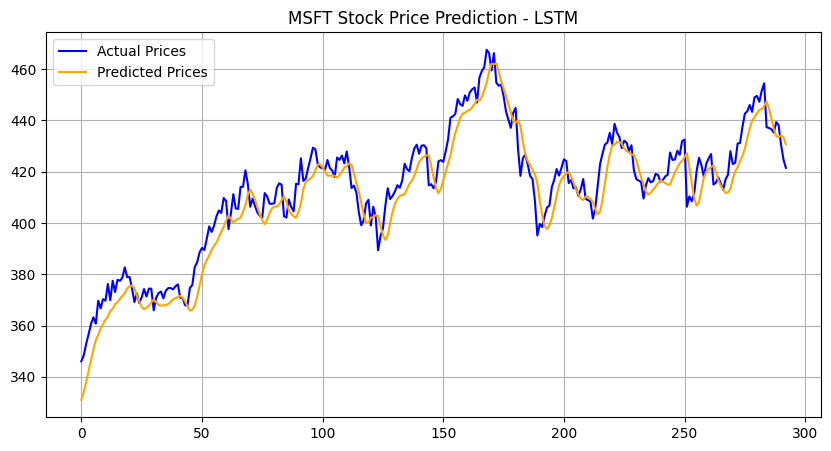

In [43]:
#Vẽ biểu đồ  #MSFT

plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('MSFT Stock Price Prediction - LSTM')
plt.legend()
plt.grid(True)
plt.show()

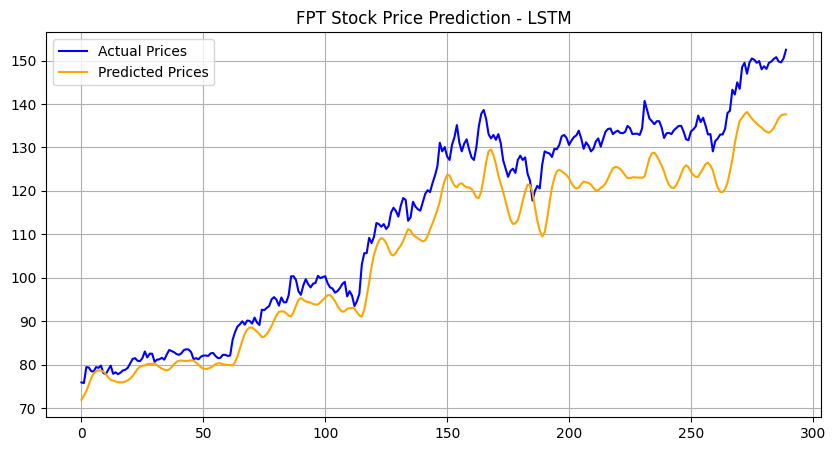

In [55]:
#Vẽ biểu đồ FPT

plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('FPT Stock Price Prediction - LSTM')
plt.legend()
plt.grid(True)
plt.show()

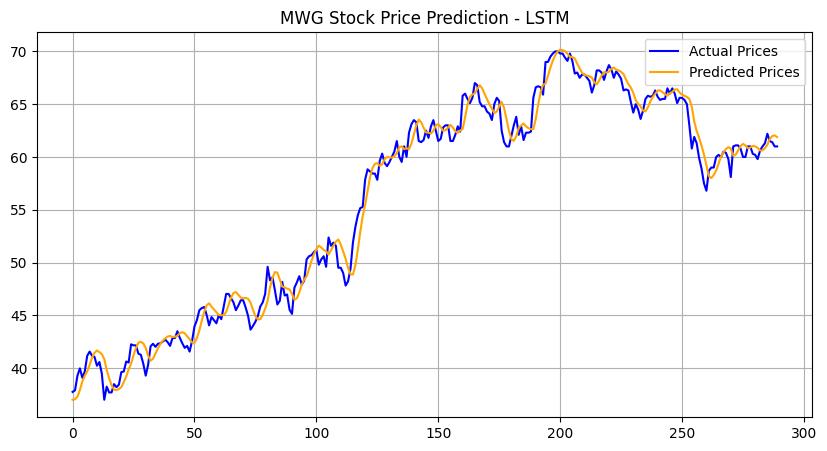

In [9]:
#Vẽ biểu đồ MWG

plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('MWG Stock Price Prediction - LSTM')
plt.legend()
plt.grid(True)
plt.show()

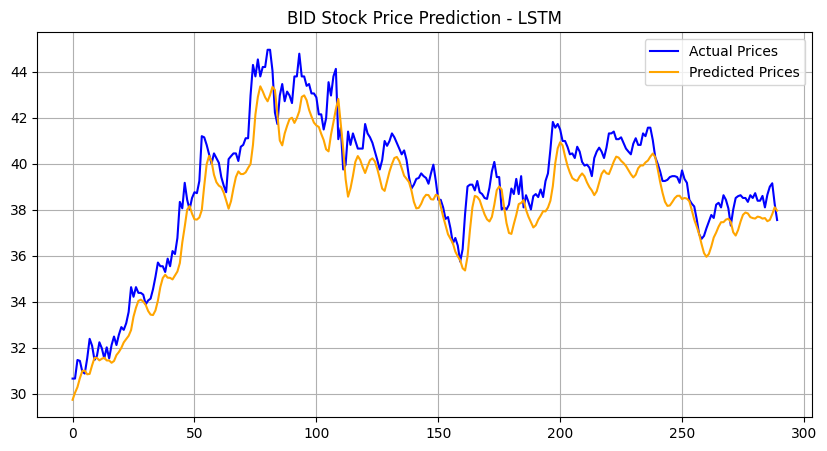

In [49]:
#Vẽ biểu đồ BID

plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('BID Stock Price Prediction - LSTM')
plt.legend()
plt.grid(True)
plt.show()

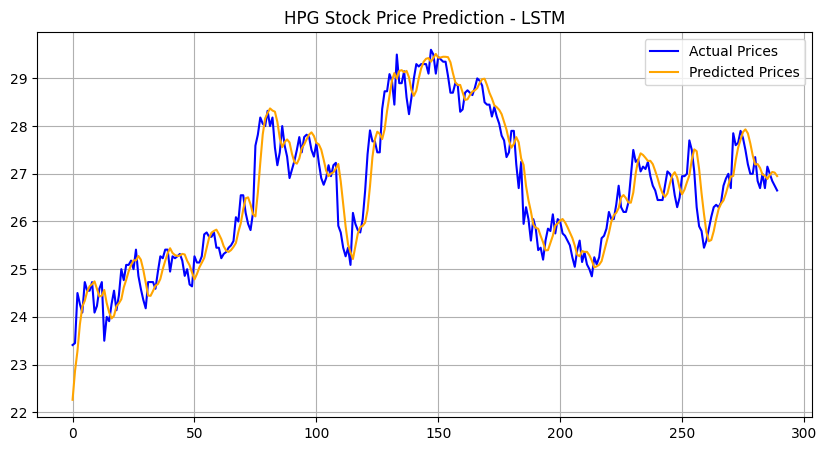

In [61]:
#Vẽ biểu đồ HPG

plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('HPG Stock Price Prediction - LSTM')
plt.legend()
plt.grid(True)
plt.show()

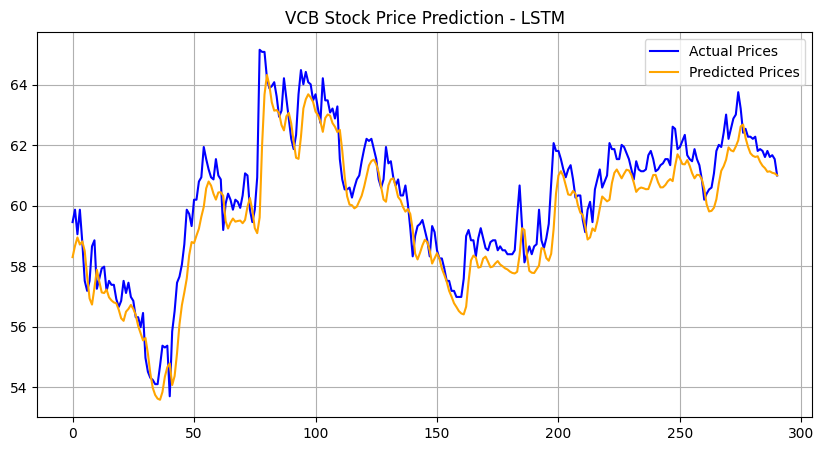

In [21]:
#Vẽ biểu đồ VCB

plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('VCB Stock Price Prediction - LSTM')
plt.legend()
plt.grid(True)
plt.show()